# Bayesian Statistical Inference: III

*N. Pol (2025)*

Material in this lecture and notebook is based upon the lectures of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18). Also the "Inference2" lecture of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), Karen Leighly's [Bayesian Stats](http://seminar.ouml.org/lectures/bayesian-statistics/), and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

---

## Contents
* [Monte Carlo Methods & Markov Chains](#one)
* [Markov Chain Monte Carlo (MCMC) Techniques](#two)
* [The Metropolis-Hasting Algorithm](#three)
* [Worked Example](#four)

---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

Please pause for a few minutes and install these two packages `emcee`, `pymc3`, and `PTMCMCSampler` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn.

In [4]:
# !pip install emcee

In [5]:
# !pip install pymc

!pip install git+https://github.com/dfm/acor@master

In [6]:
# !pip install git+https://github.com/jellis18/PTMCMCSampler@master

## Monte Carlo Methods & Markov Chains <a class="anchor" id="one"></a>

### Motivation

Consider the problem of estimating location and scale parameters for homoscedastic data drawn from a Gaussian distribution that we looked at in `Lecture_8`. We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)

It was easy to *numerically* integrate the posterior pdf to find the marginal distributions, and find its maximum, using a brute-force grid search because it was only a $2$D problem. With $100$ grid points per coordinate it was only $10^4$ values. 

However, **what about high parameter dimensions?**
- Even in a case of rather simple $5$D problem (as we'll discuss later today), we'd have $10^{10}$ values! And often we work with models of much higer dimensionality (it can be thousands!). **Brute-force grid methods are not feasible beyond a few dimensions**, and even then can be waste of time. 
- You could **simply randomly sample the grid at every point**, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a ***Markov-Chain Monte Carlo (MCMC)***. MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most sample density in regions that are closest to the maximum probability. Then, you can post-process the “chain” of points to infer the posterior distribution and uncertainty regions.

Ivezic, Figure 5.22 shows a problem similar to the one above, done with a Markov Chain Monte Carlo algorithm.  The dashed lines are the known (analytic) solution.  The solid lines are from the MCMC estimate with 10,000 sample points.

![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)

### What does Monte Carlo mean?

In case you are not familiar with Monte Carlo methods, it derives from the name of an administrative area of the Principality of Monaco ([Monte Carlo](https://www.wikiwand.com/en/Monte_Carlo)) known for high-stakes casinos and gambling. Gambling and random sampling go hand in hand together.

![](https://www.thomascook.com/.imaging/mte/thomascook-theme/og-image/dam/legacy/heros/citybreaks/monte-carlo/montecarlohero.jpg/jcr:content/montecarlohero.jpg)

**EXAMPLE:** 
- You have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 
- We can use the information that we *do* know to numerically compute $\pi$.

1. We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).
2. We put down random points within the square and note which ones land in the circle.
3. The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.
4. Using more random points yields more precise estimates of the area.

<font color='red'>Try it below. How many draws does it take to get the error down to 1 part in a thousand?</font>

We'll consider one quadrant of a square of sides [-1,1] in which we inscribe a circle (actually just one quarter of a circle).

In [10]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
ax.axis([0, 1, 0, 1]);
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

In [21]:
# Lay down M random points.  Tally how many are within a unit circle.
M = 1000
x = stats.uniform(loc=0.5,scale=1).rvs(M) # M random draws between 0 and 1
y = stats.uniform(loc=0.5,scale=1).rvs(M) # M random draws between 0 and 1

r2 = x**2 + y**2 # equation for radius of cirle in x,y

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

# Plot points in square
plt.plot(x, y, '.k', 
         markersize=3, c='blue') 

# Plot points also in circle
plt.plot(x[r2 < 1], y[r2 < 1], '.k', 
         markersize=3, c='red') 

#ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
    
# A_square = d^2, Acircle = pi*d^2
piEst = 4 * np.sum(r2 < 1) / M # pi = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0} for {1} draws with fractional error {2}.".format(piEst, M, 
                                                                              np.abs((np.pi-piEst)/np.pi)))

Estimate of pi is 0.348 for 1000 draws with fractional error 0.8892281596080409.


/var/folders/jr/6thm8wn52bv9_gbqq6c_j_ph0000gn/T/ipykernel_4630/1643640772.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, '.k',
/var/folders/jr/6thm8wn52bv9_gbqq6c_j_ph0000gn/T/ipykernel_4630/1643640772.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x[r2 < 1], y[r2 < 1], '.k',


See also [this Khan Academy simulation](https://www.khanacademy.org/computer-programming/monte-carlo-finding-the-value-of-pi/6530004791197696/embedded?embed=yes&article=yes&editor=no&buttons=no&author=no&autoStart=yes&width=610&height=420).

- In general, ***Monte Carlo methods*** use random sampling to obtain a numerical result (e.g., the value of an integral), where there is no analytic result or it is difficult to obtain.
- In the case of the circle above, we have computed the intergral: $\int\int_{x^2+y^2\le 1} dx dy.$

Recall ***Monte Carlo integration***. 
- Our goal was to integrate $\int g(x)f(x)dx$. 
- We could do this on a grid of $x$, such that $\int g(x)f(x)dx \approx \sum_{i=1}^N g(x_i)f(x_i)\Delta x$, where we use the probability distribution at each grid point $f(x_i)$ as weights for the sum over $g(x_i)$.
- But we might waste terms in the sum over low probability areas. If we have random draws from $f(x)$ then the *density* of those points in $x$ directly represent the weighting we desire. We will get most weight in regions of high probability. 
- We can think of our random samples as $f(x)$ being a sum of $\delta$ functions at the sampled points, all overlapping to give high density at the high probability regions. The integral is then 

$$ \int g(x)f(x)dx \approx \frac{1}{N}\int g(x)\sum_i^N\delta(x_i)dx = \frac{1}{N}\sum_i^N \int g(x)\delta(x_i)dx = \frac{1}{N}\sum_i^N g(x_i).$$

### What is a Markov Chain?

A Markov Chain is defined as 

> a sequence of random variables where a parameter depends *only* on the preceding value. Such processes are "memoryless".  
 
Mathematically, we have

$$p(\theta_{i+1}|\theta_i, \theta_{i-1}, \theta_{i-2}, \cdots) = p(\theta_{i+1}|\theta_i).$$

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:

$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$

This is called the ***principle of detailed balance*** or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).

**EXAMPLE** 

If you are an (*electromagnetic*) astronomer and you want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy).  From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$

***NOTE:*** These numbers could be somewhat related to the mercurial weather we have in Lubbock.

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

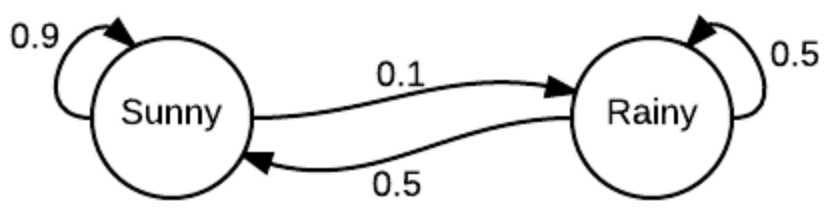

Sampling for $10,000$ days using this prescription gives a chain that looks like this:

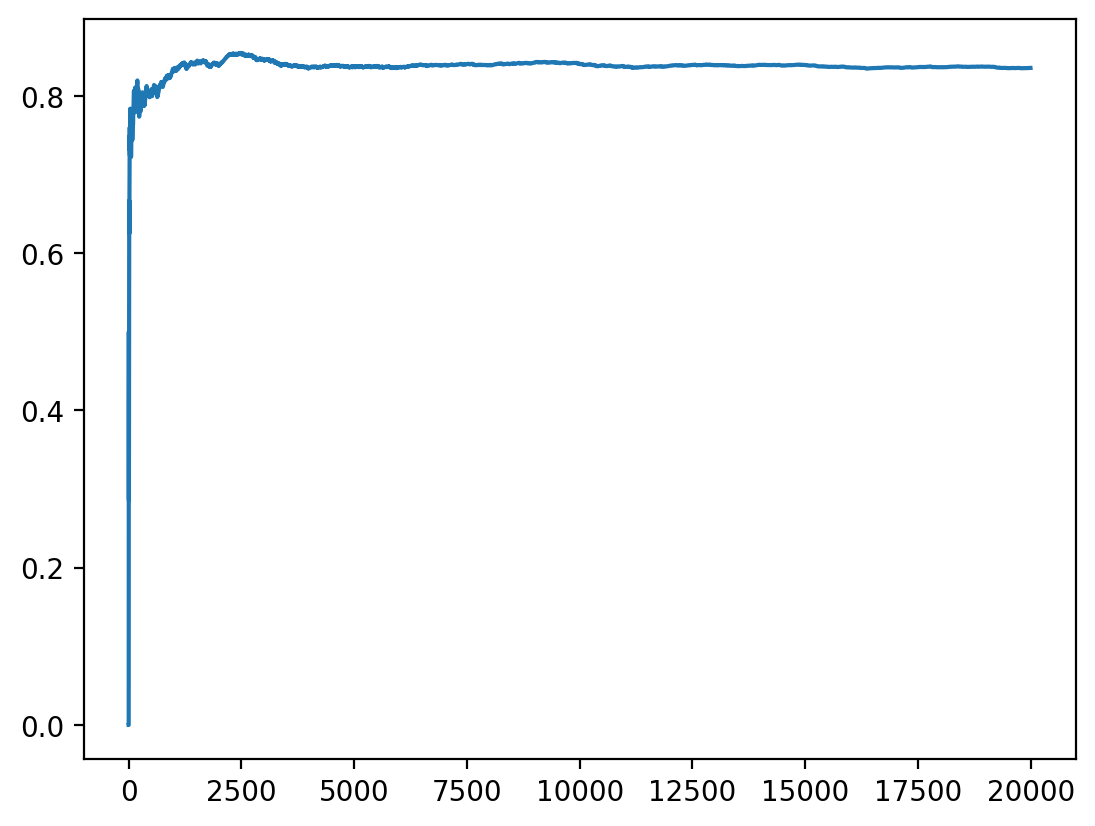

In [24]:
# Let's start off on a cloudy day
# Cloud = 0
# Clear = 1
weather = [0]

for ii in range(1,20000):
    # implementing forecasts based on above probabilities
    if weather[ii-1] == 1:
        weather.append(np.random.choice(np.array([0, 1]),
                                        p=np.array([0.1, 0.9])))
    elif weather[ii-1] == 0:
        weather.append(np.random.choice(np.array([0, 1]),
                                        p=np.array([0.5, 0.5])))
weather = np.array(weather)

running_clear = np.cumsum(weather)[1:]/np.arange(weather.shape[0])[1:]
# plot the running average
plt.plot(running_clear)
plt.show()

- The above figure is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples. 
- A histogram of the above plot reveals the distribution of $p(\mathrm{clear})$. We can use this to determine the most likely value and an error on our estimate.

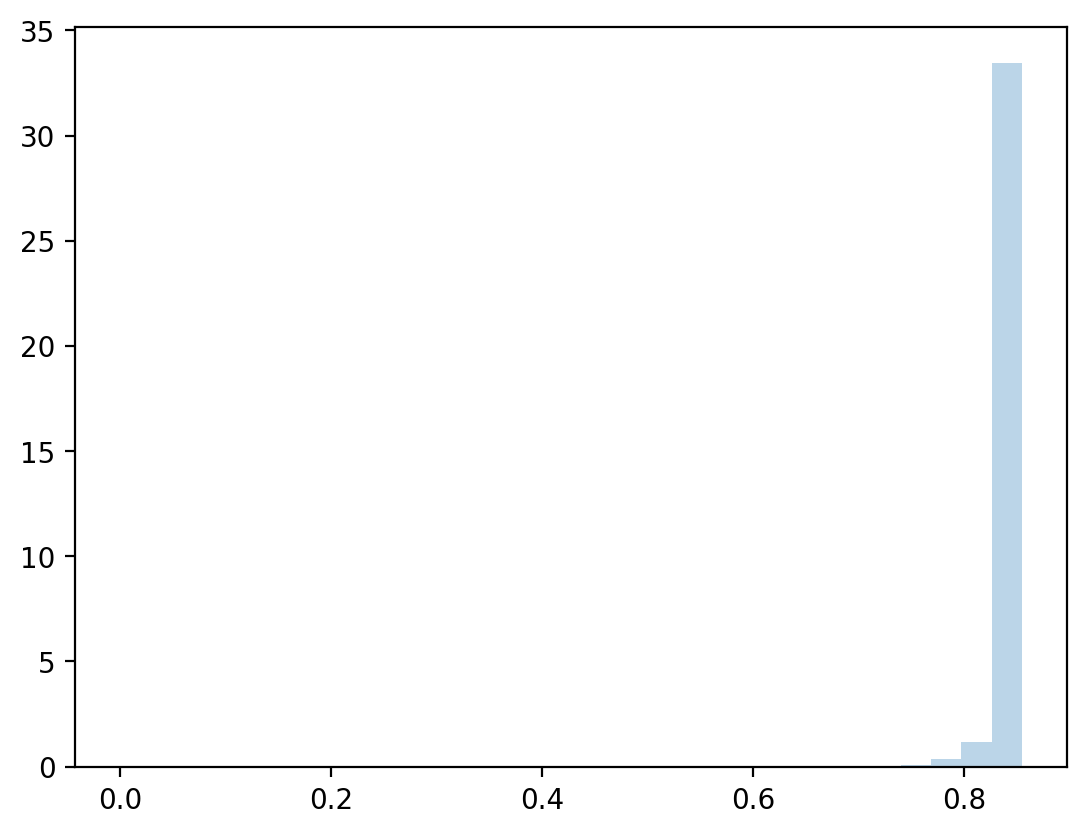

In [27]:
plt.hist(running_clear, bins=30, density=True, alpha=0.3);
plt.show()

- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!!!***

<font color='red'>Try the above example again but this time start with a clear day. Also experiment with chopping off different numbers of initial points as burn-in from `running_clear`.</font>

## Markov Chain Monte Carlo (MCMC) Techniques <a class="anchor" id="two"></a>

> The use of **Markov chains** to perform **Monte Carlo integration** is called ***Markov Chain Monte Carlo (MCMC)***.

Given such a Markov chain of length $N$ that corresponds to draws of $p(\theta)$, integrals can be estimated as

$$ \int g(\theta) \, p(\theta) \, d\theta \approx {1 \over N} \sum_{i=1}^Ng(\theta_i).$$

- To estimate the expectation value for $\theta_1$ (i.e., $g(\theta)=\theta_1$), we simply take the mean value of all $\theta_1$ in the chain.
- To visualize the posterior pdf for parameter $\theta_1$, marginalized over all other parameters, $\theta_2, \ldots, \theta_k$, we can construct a histogram of all $\theta_1$ values in the chain, and normalize its integral
to 1. 
- To get a MAP (*maximum a posterori*) estimate for $\theta_1$, we find the maximum of this marginalized pdf.

In order for a Markov chain to reach a **stationary distribution** proportional to $p(\theta)$, the probability of arriving at a point $\theta_{i+1}$ must be proportional to $p(\theta_{i+1})$,

$$ p(\theta_{i+1}) = \int  T(\theta_{i+1}|\theta_i)  \,   p(\theta_i) \,    d \theta_i, $$

where the transition probability $T(\theta_{i+1}|\theta_i)$ is called the **proposal distribution** (and it is assumed that we know how to compute $p(\theta_i)$). The proposal distribution is exactly what it sounds like-- it proposes new positions to jump to in parameter space.

This requirement will be satisfied when the transition probability satisfies **the principle of detailed balance**

$$ T(\theta_{i+1}|\theta_i)  \,  p(\theta_i) = T(\theta_i|\theta_{i+1})  \,  p(\theta_{i+1}). $$

Most of the difficulty in MCMC comes from either determining the burn-in or deciding how to step from one position to another.  In our circle example above, we drew points in a completely random manner. However, that's sub-optimal. ***We want random sampling that preferentially steps into regions of high probability density.***  

The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  

## The Metropolis-Hastings Algorithm <a class="anchor" id="three"></a>

**The Metropolis-Hastings algorithm** adopts the following acceptance probability for newly proposed points to step to:

$$ p_{\rm acc}(\theta_i,\theta_{i+1}) = { p(\theta_{i+1}) \over p(\theta_i) }, $$

where the proposed point $\theta_{i+1}$ is drawn from an *arbitrary* symmetric density distribution $T(\theta_{i+1}\,|\,\theta_i)$. Since it is symmetric, the **ratio of transition probabilities cancels out and detailed balance is ensured**. A Gaussian distribution centered on the current point $\theta_i$ is often used for $T(\theta_{i+1}|\theta_i)$.

This algorithm guarantees that the chain will reach an equilibrium, or stationary, distribution, and it will approximate a sample drawn from $p(\theta)$! 

**In summary, the Metropolis-Hastings algorithm consists of these steps:**

1. Given $\theta_i$ and $T(\theta_{i+1}|\theta_i)$, draw a proposed value for $\theta_{i+1}.$ 
2. Compute acceptance probability $p_{\rm acc}(\theta_i,\theta_{i+1})$.
3. Draw a random number between 0 and 1 from a uniform distribution; if it is smaller than $p_{\rm acc}(\theta_i,\theta_{i+1})$, then accept $\theta_{i+1}$. 
4. ***If $\theta_{i+1}$ is accepted added it to the chain. If not, add $\theta_{i}$ to the chain.***
5. Use the chain (of $\theta$ values) for inference; e.g. a histogram of $\theta$ is an estimator of the posterior pdf for $\theta$, $p(\theta)$, and the expectation value for $\theta$ can be computed from 

  $$ I = \int g(\theta) \, p(\theta) \, d\theta = \frac{1}{N} \sum_{i=1}^N g(\theta_i).$$

where N is the number of elements in the chain (e.g. the expectation value for $\theta$ is simply the mean value of chain elements). 

***Step 3*** is very important. If we only accepted points of higher probability then we would only move up the posterior density to find its maximum. But we want to map out the full posterior density, so sometimes we must settle for less!

### Corner Plots

If you are using MCMC, then you probably have multiple parameters (otherwise, you'd be doing something easier).  So, it helps to display the parameters two at a time, marginalizing over the other parameters.  An example is given in Ivezic, Figure 5.24, which compares the model results for a single Gaussian fit to a double Gaussian fit. These are called `corner` or `triangle` plots, which we've discussed before.

The most popular packages to make these are [corner](https://corner.readthedocs.io/en/latest/) and [chainconsumer](https://samreay.github.io/ChainConsumer/).

![Ivezic, Figure 5.24](http://www.astroml.org/_images/fig_model_comparison_mcmc_1.png)

## Worked Example <a class="anchor" id="four"></a>

We'll end by going through the example given at
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

Let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points, using [numpy.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html). Our goal is to estimate $\mu$.

In [28]:
import scipy as sp
import pandas as pd
from scipy.stats import norm

np.random.seed(123)

data = np.random.randn(100)
plt.figure(figsize=(4,4))
plt.hist(data, bins=10, density=True, alpha=0.3)
plt.xlabel('x')
plt.ylabel('data density')

Text(0, 0.5, 'data density')

Now we have to pick a model.

- We'll assume a Gaussian likelihood distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  
- We'll also assume a Gaussian distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write an analytic function for our posterior distribution as follows (*recalling that the product of two Gaussians is also a Gaussian*):

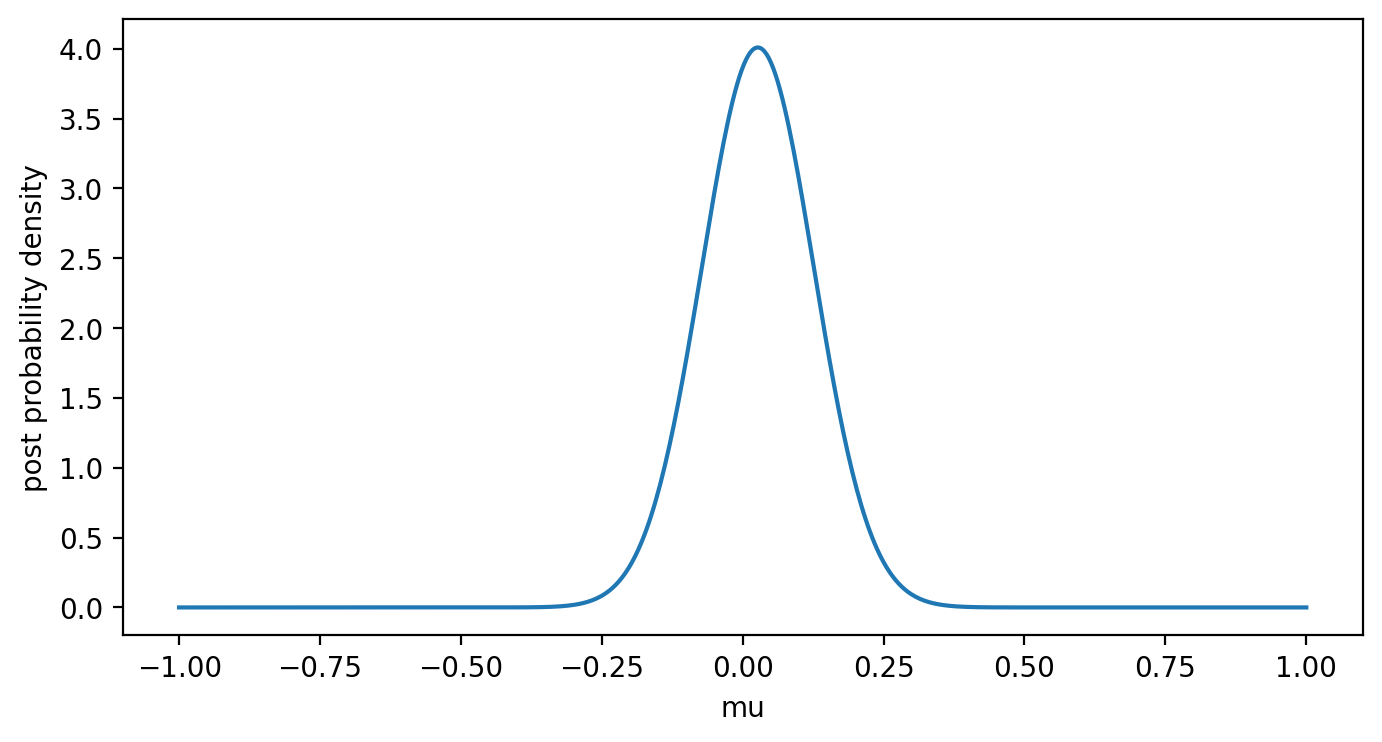

In [32]:
# Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    
    # Error-weighted sum of prior and average of data
    # Recall the product of 2 Gaussians
    
    # This is the Gaussian MLE estimate for the prior: mu_0 / sigma_0**2
    # This is the Gaussian MLE estimate for the likelihood: data.sum() / sigma**2
    # We are deriving the mean from the sum of the data values
    
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    
    return norm.pdf(xgrid, mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,4))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post probability density')
plt.show()

Let's try this instead with MCMC. 

- We'll start with a trial $\mu_0 = -1$ and evaluate.
- Then we'll jump to a new position using the Metropolis-Hastings algorithm mentioned above.  
- Next we evaluate whether that jump was "good" or not -- by seeing if the value of the likelihood $\times$ prior increases.  

*We always work with the un-normalized posterior (i.e. likelihood $\times$ prior) in these MCMC algorithms (or equivalently the un-normalized log-posterior which equals log-likelihood + log-prior).*

<font color='red'>Read through the first function below to understand how it is implementing the Metropolis-Hastings algorithm. But don't worry about the second function, which is just setting up plots.</font>

In [36]:
## Execute this cell
## See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, 
            plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        # changing the width of this distribution changes how big the jump is between trials.
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept > 1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                          mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

## Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, 
                  mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', 
            title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, 
                                                                                       prior_current, 
                                                                                       mu_proposal, 
                                                                                       prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    
    ax2.hist(data,alpha=0.5,density='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 
                                                                              1e14*likelihood_current, 
                                                                              mu_proposal, 
                                                                              1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, 
                                                     mu_prior_mu, 
                                                     mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, 
                                                  mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, 
                                                   mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, 
                                                                            posterior_current, 
                                                                            mu_proposal, 
                                                                            posterior_proposal)) 
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    plt.show()

Each row below is a single iteration through our Metropolis-Hastings sampler.

- **1st column = prior distribution**. The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).


- **2nd column = likelihood**.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed mu. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current mu.


- **3rd column = (normalized) posterior distribution**.


- **4th column = trace** (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values

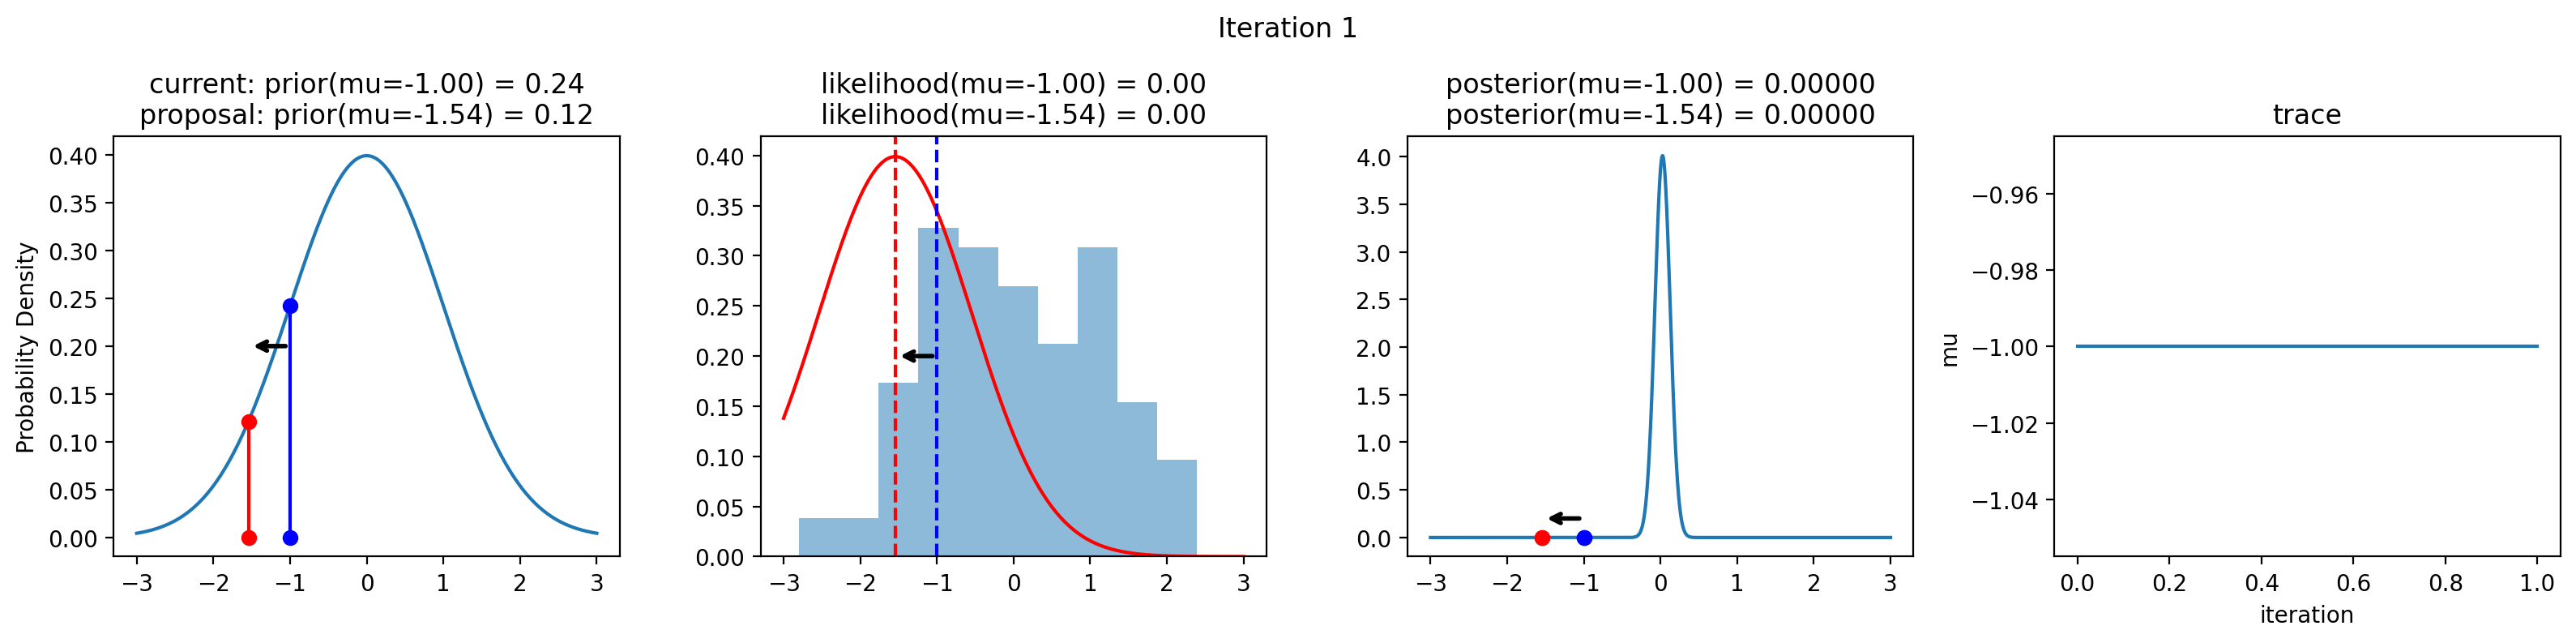

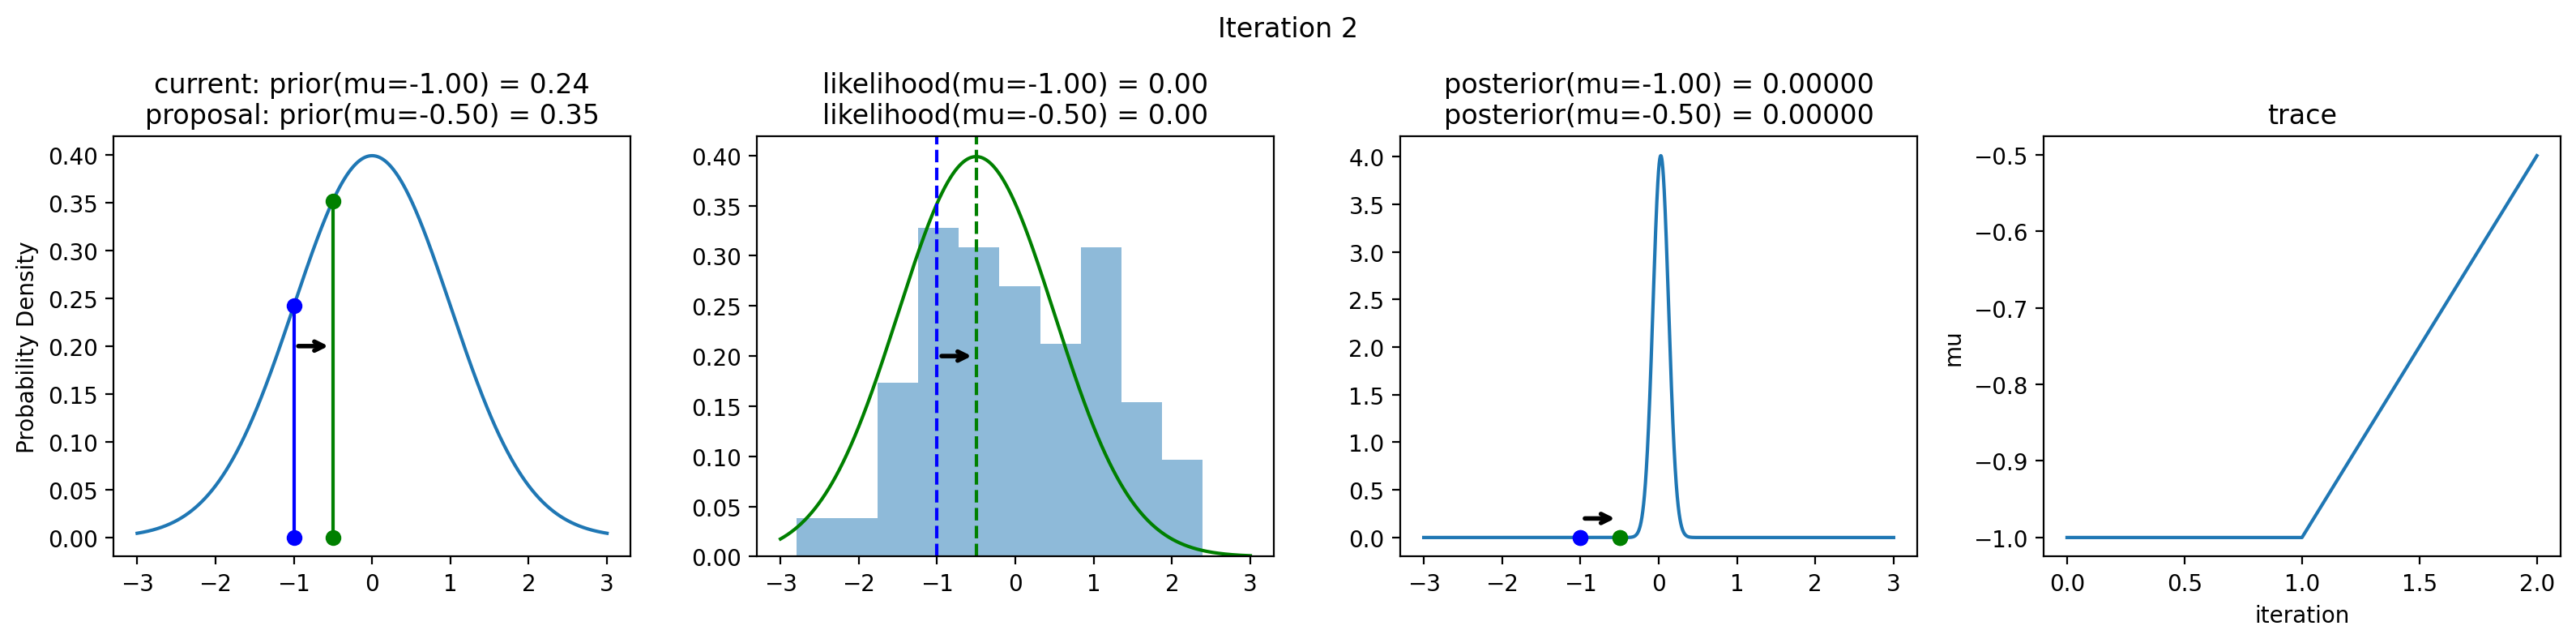

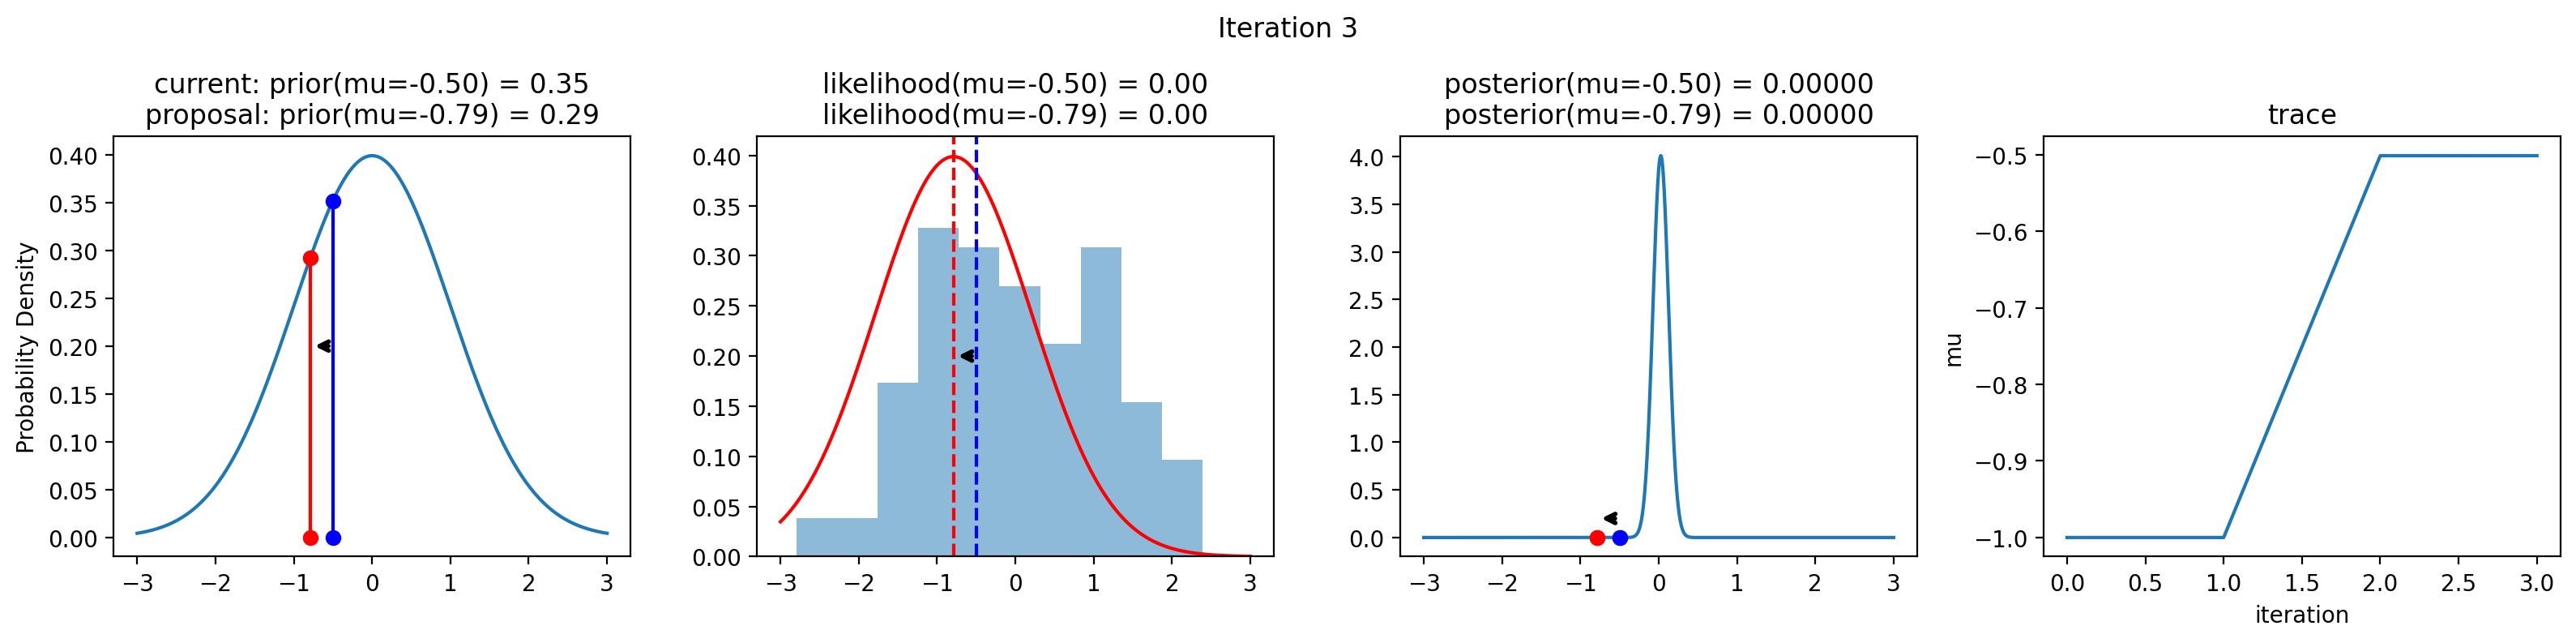

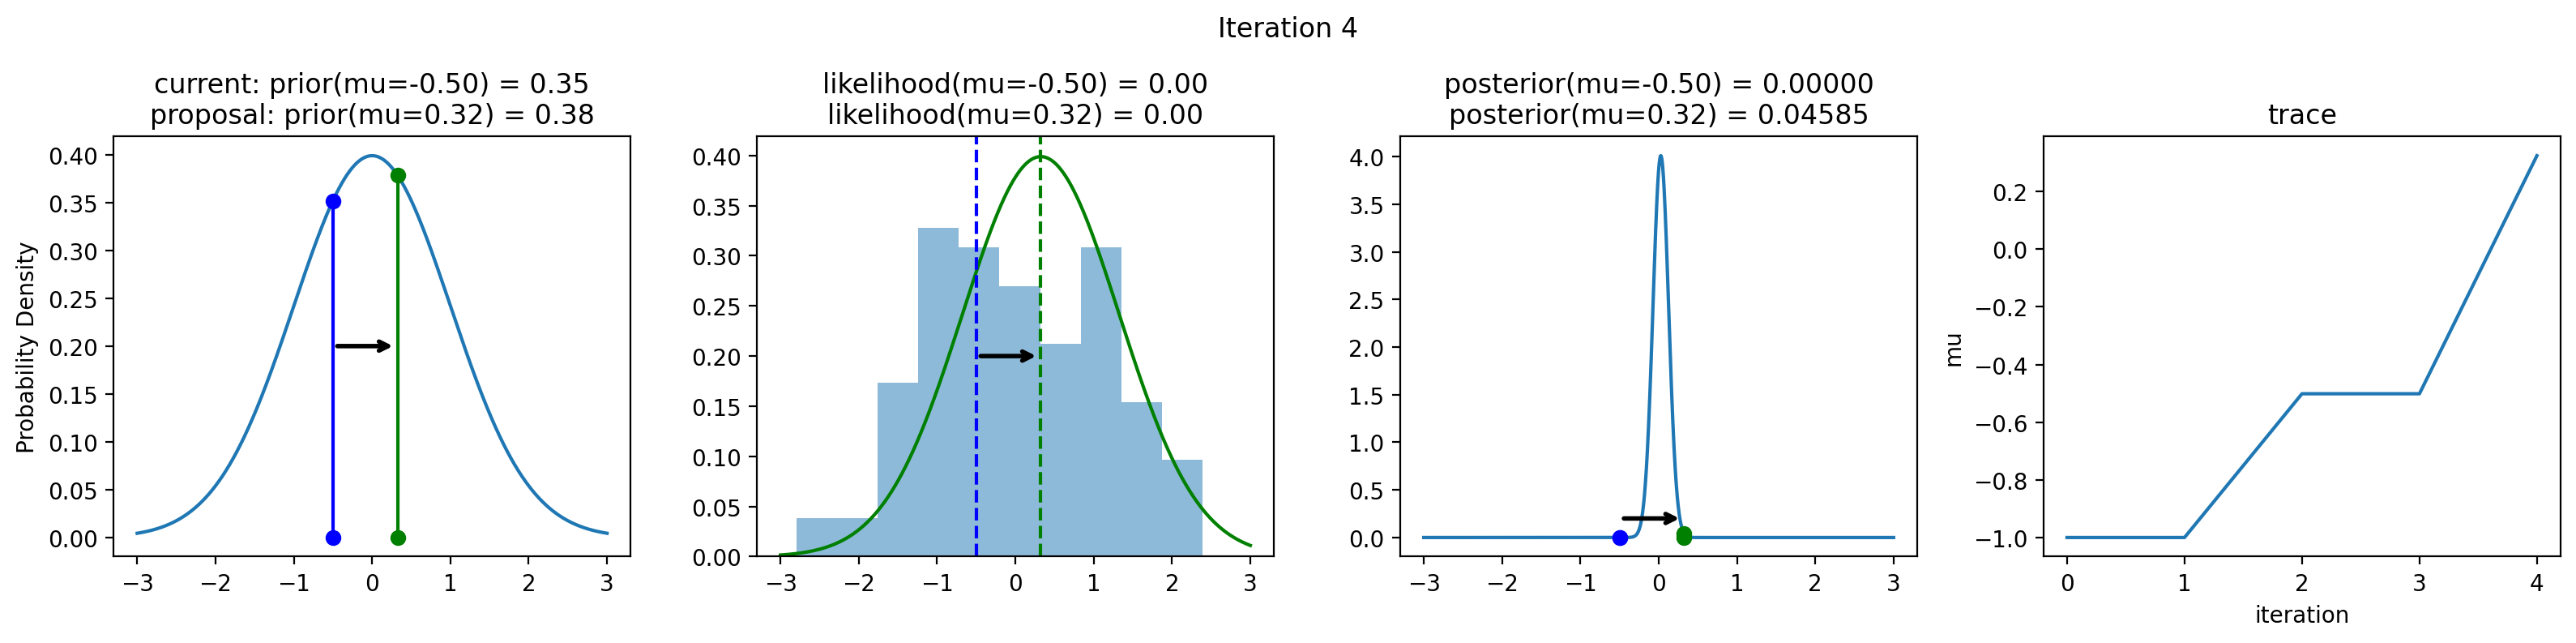

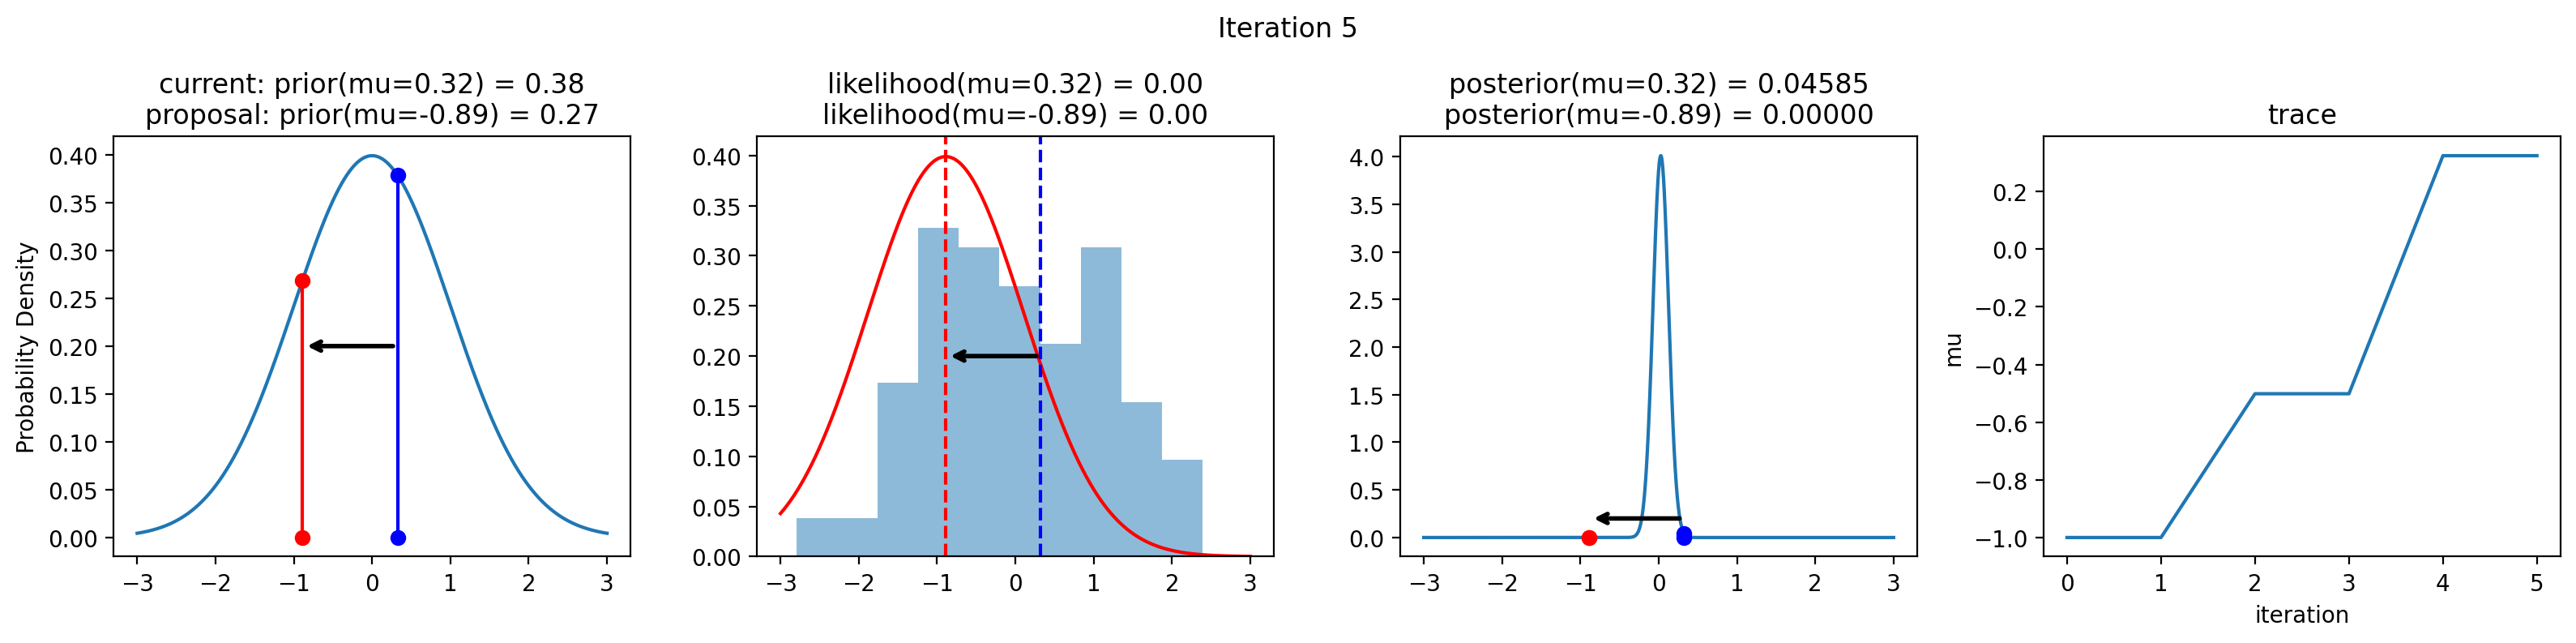

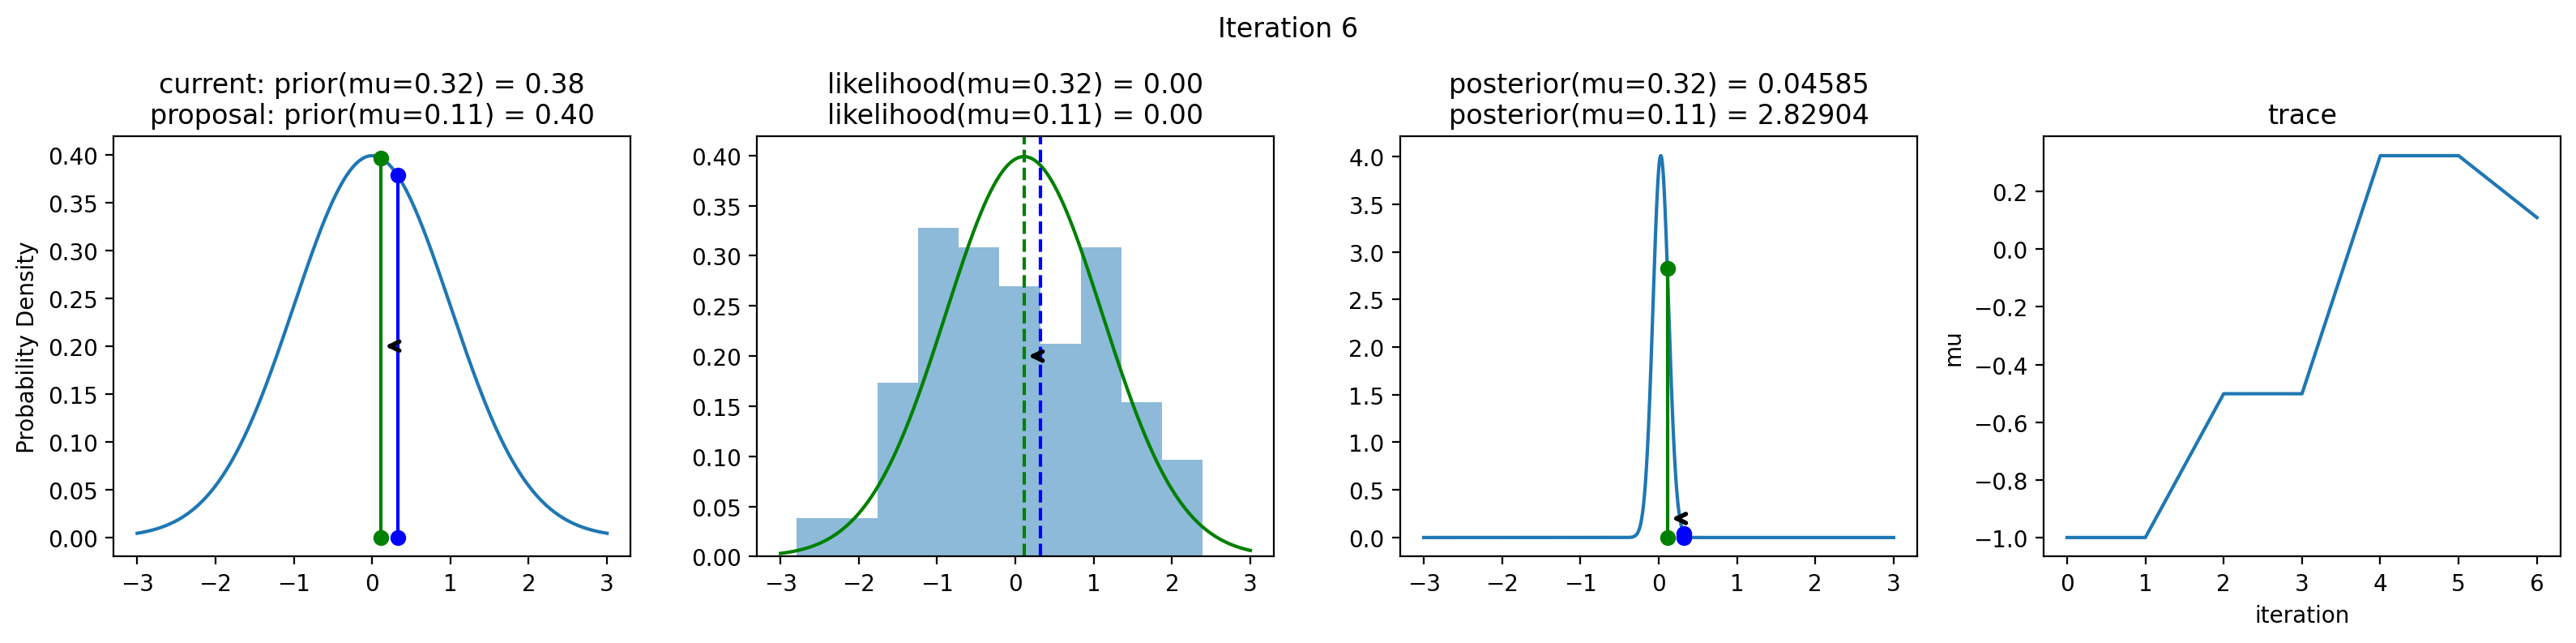

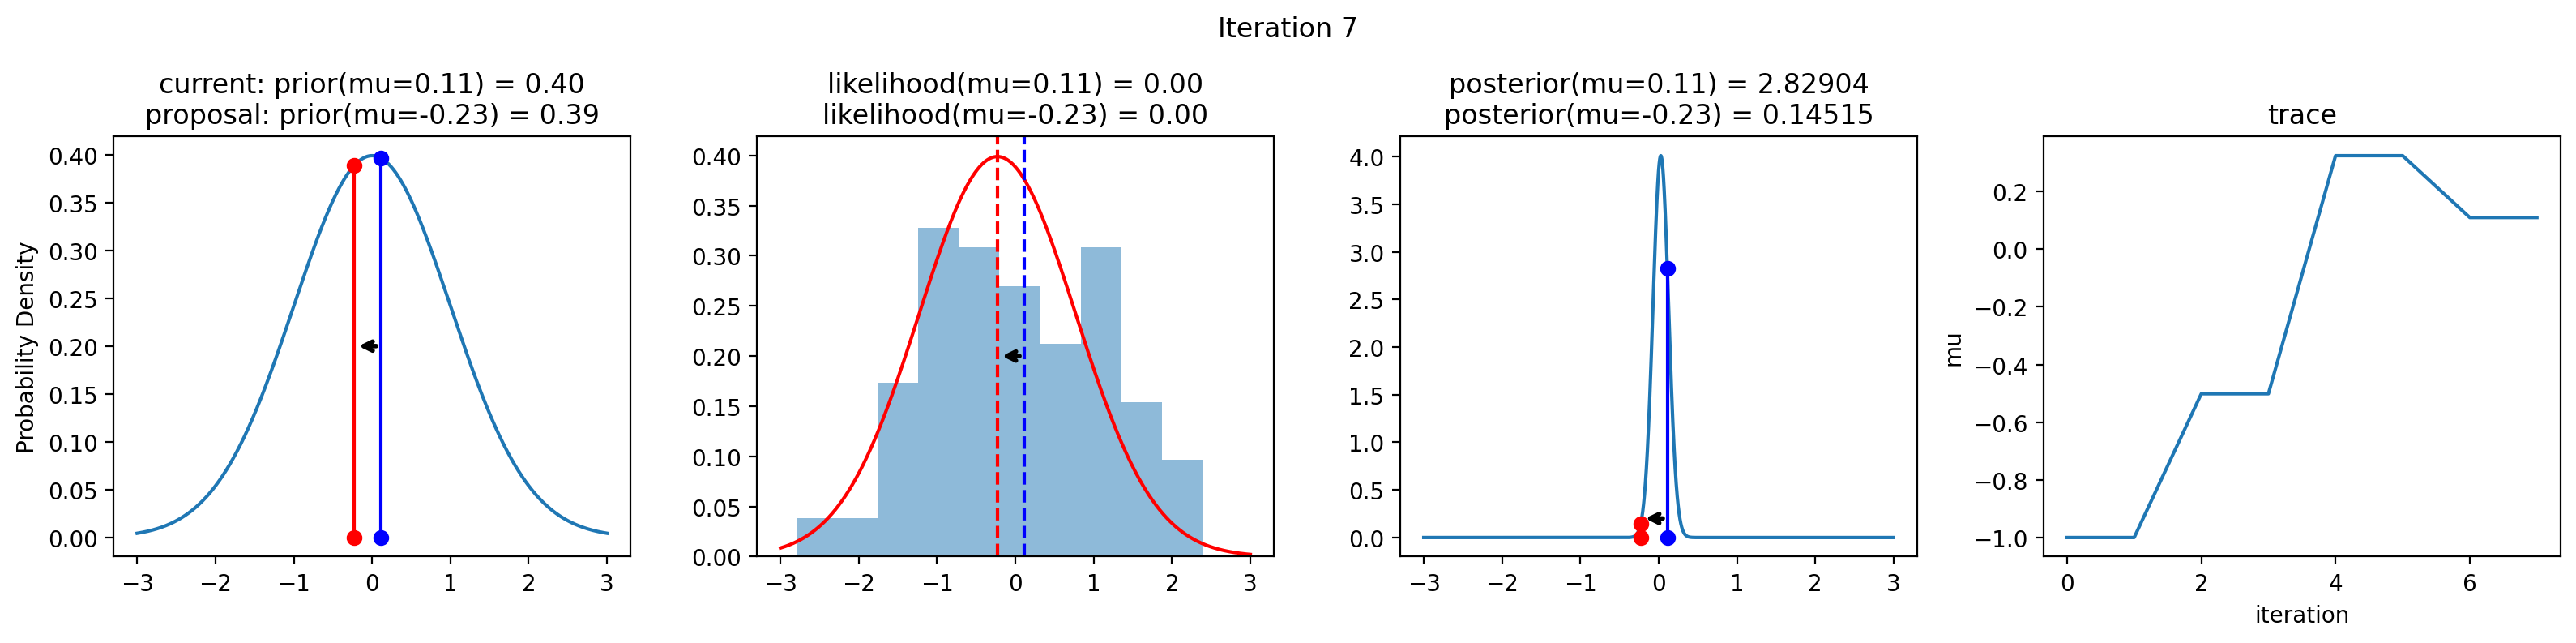

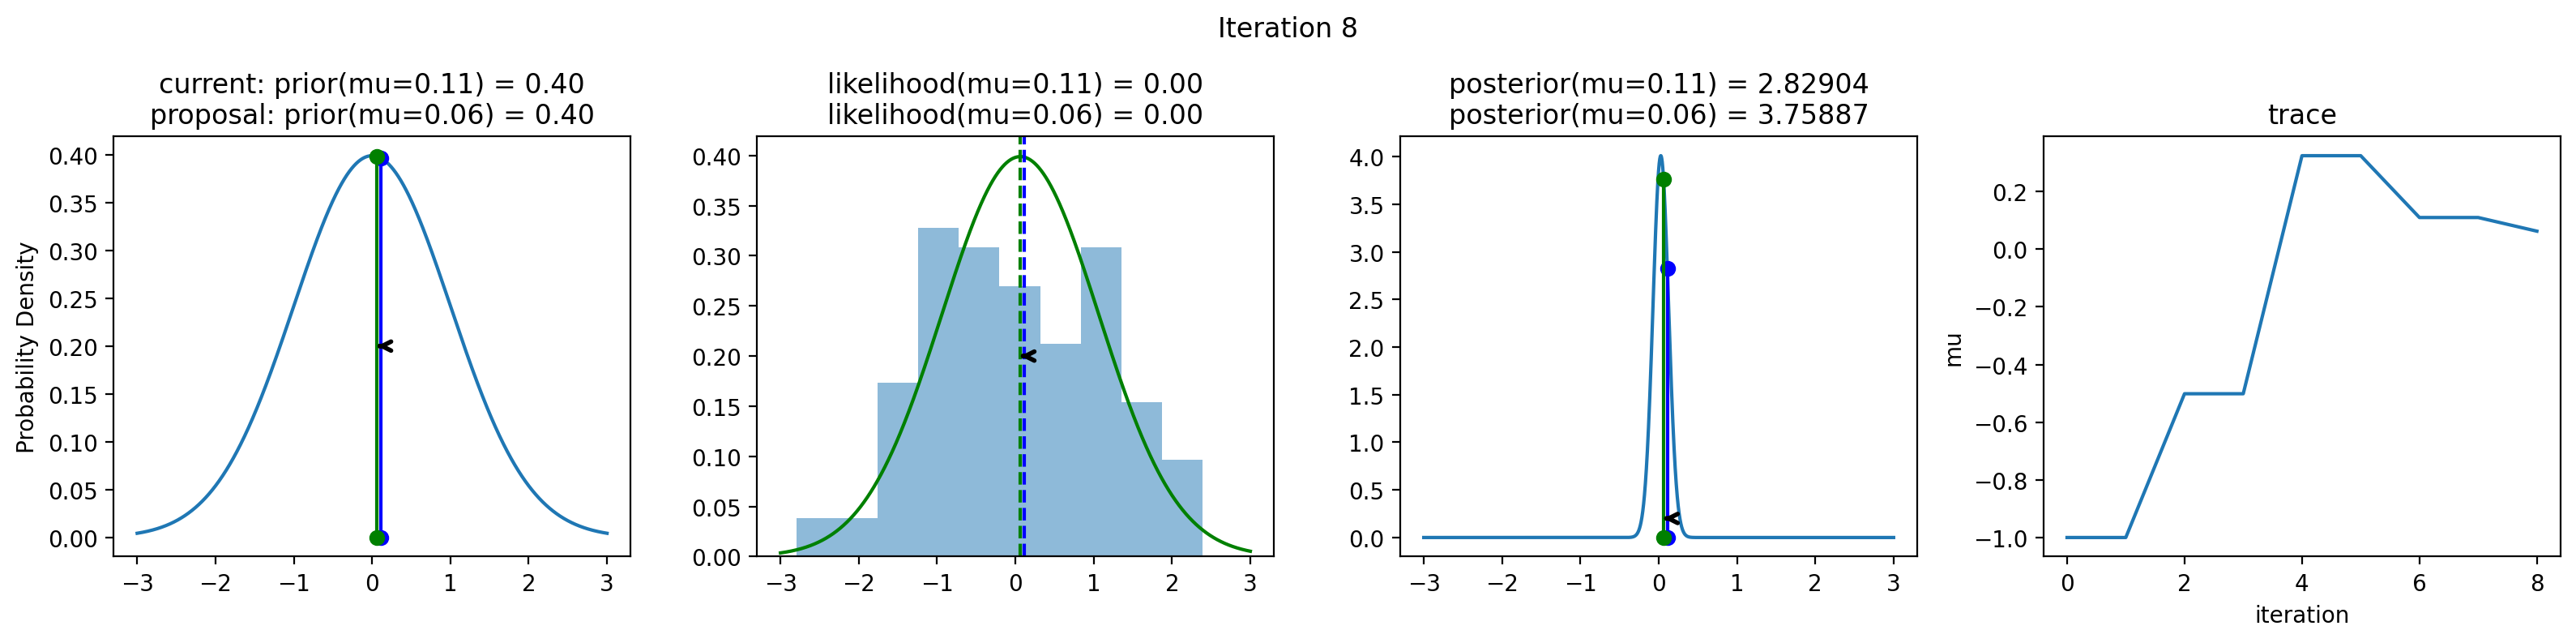

In [37]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

What happens when we do this lots of times? You might need to wait for a minute. Consider this a lesson in that running MCMCs can sometimes feel like watching paint dry.

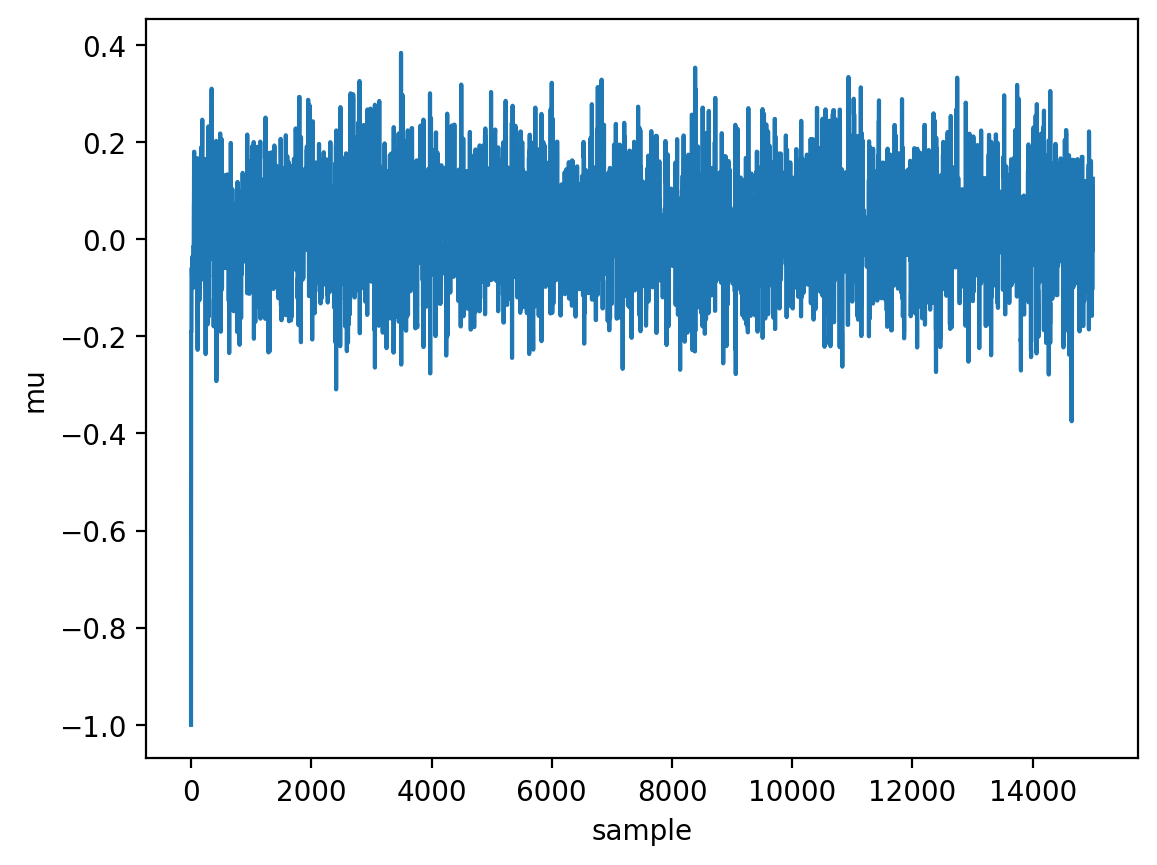

In [46]:
posterior = sampler(data, samples=15000, mu_init=-1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');
plt.show()

Making a histogram of these results is our estimated posterior probability distribution. Let's remove the first $500$ points as burn-in.

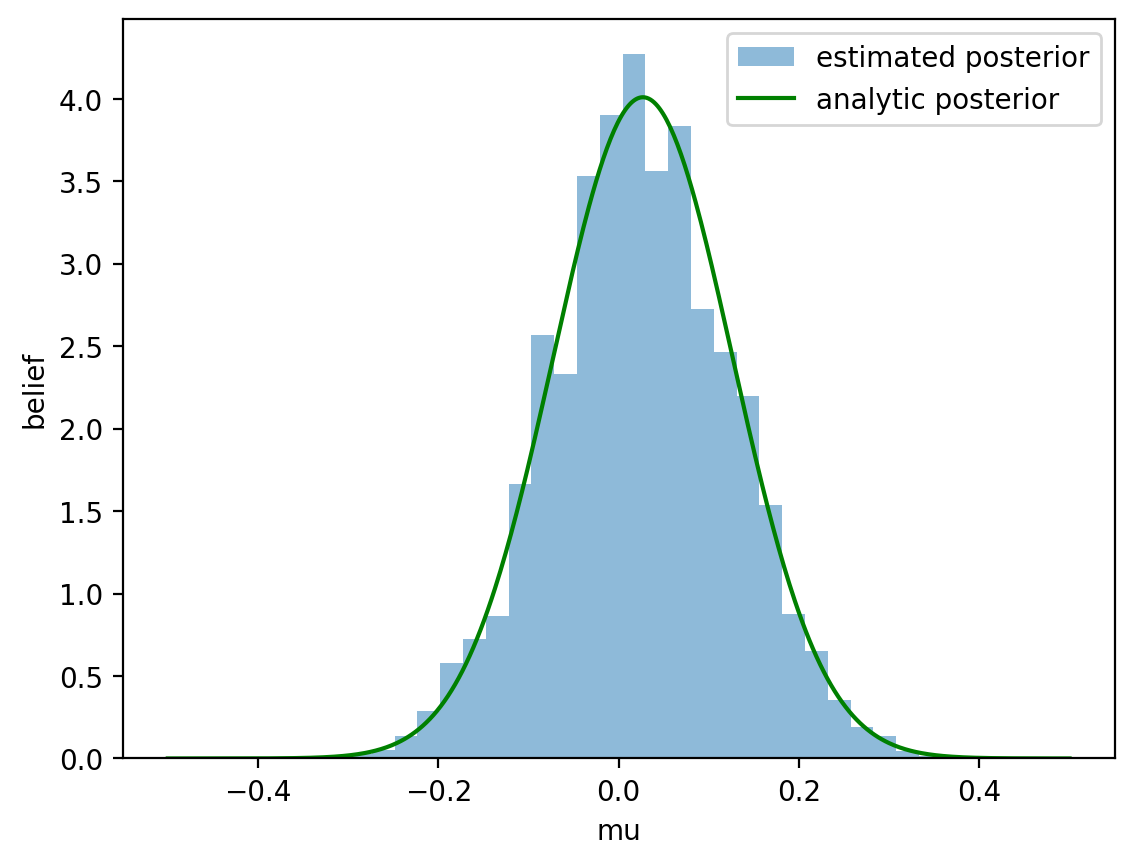

In [47]:
ax = plt.subplot()

burn = 500
ax.hist(posterior[burn:], bins=30, alpha=0.5, 
        density='True', label='estimated posterior')

xplot = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, xplot, 0, 1)
ax.plot(xplot, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');

ax.legend(fontsize=10);
plt.show()

We can compute the expected value of $\mu$, credible regions, and the MAP value.

In [48]:
# expected value
ex_mu = np.mean(posterior[burn:])

# 68% equal-tailed credible region
lower, upper = np.percentile(posterior[burn:],q=16), np.percentile(posterior[burn:],q=84)   

# MAP value
# many samplers output the likelihood x prior, 
# so it's usually than this
hist, bins = np.histogram(posterior[burn:], bins=30)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('Expected value of mu = ' + str(ex_mu))
print('68% credible region = ' + str(lower) + ' to ' + str(upper))
print('MAP value = ' + str(map_theta))

Expected value of mu = 0.024480627032736665
68% credible region = -0.07797016378002775 to 0.12733574357296162
MAP value = 0.01693475563887306


Our algorithm for deciding where to move next used a normal distribution where the mean was the current value and we assumed a width of 0.5. <font color='red'>Make this much smaller and much larger and see what it does to the sampling efficiency through the behavior of the traceplot.</font>

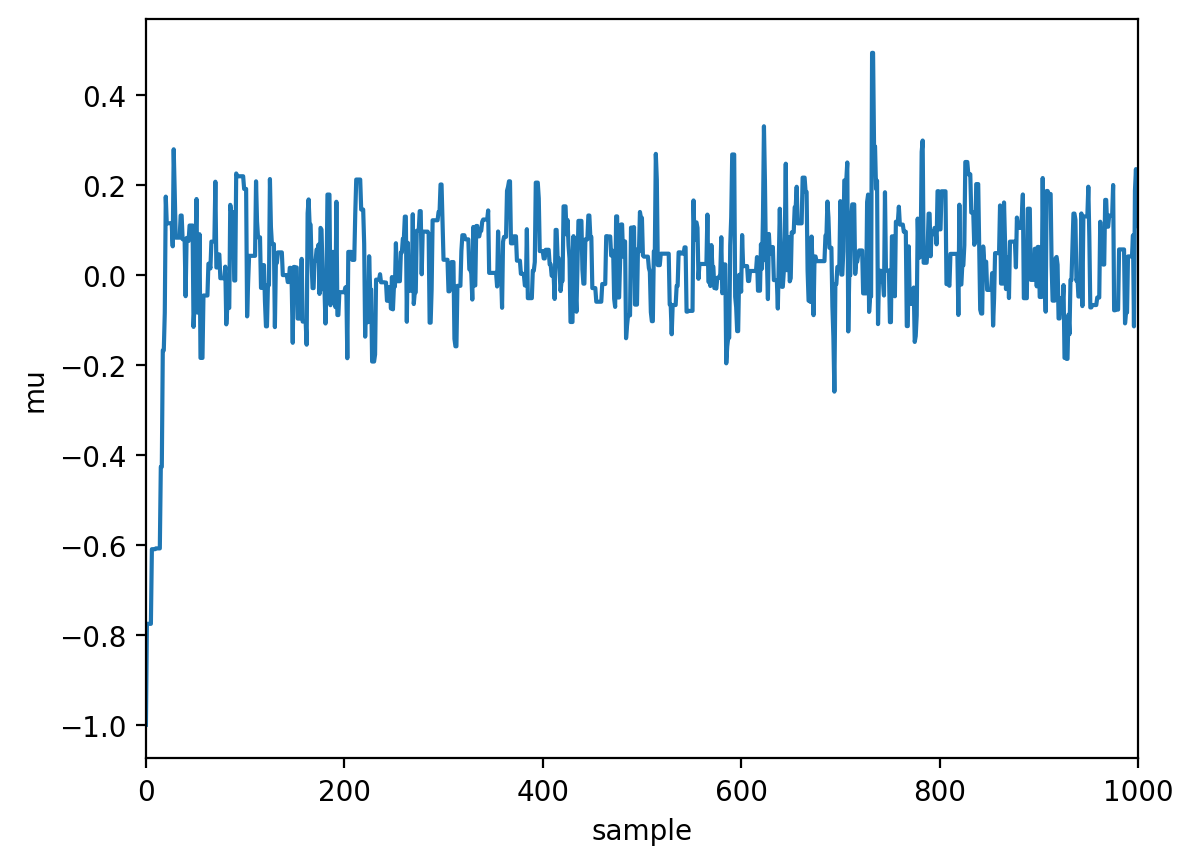

For a smaller width (but not very much small), the chain converged faster - after about 500 samples


In [65]:
#smaller width
posterior = sampler(data, samples=15000, mu_init=-1., proposal_width=0.2)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');
plt.xlim(0,1000)
plt.show()
# print("For a smaller width (but not very much small), the chain converged faster - after about 500 samples")

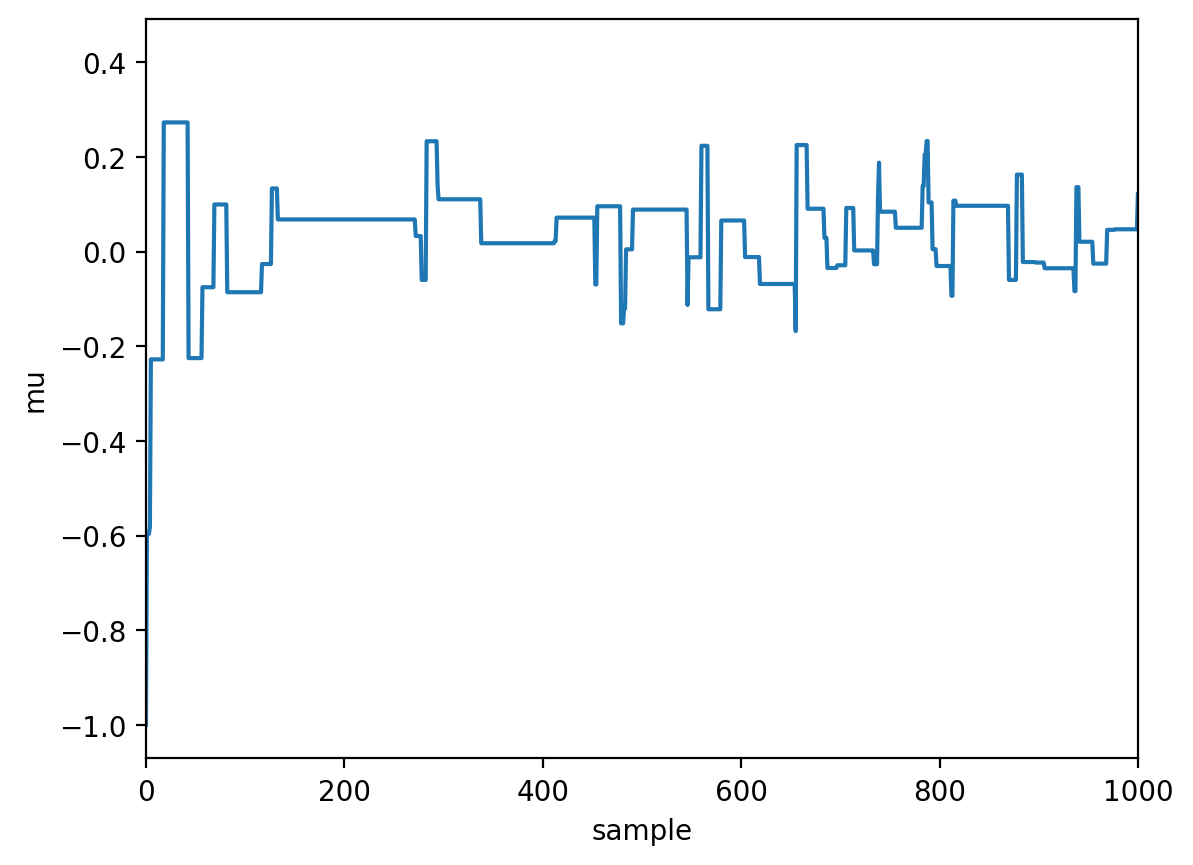

For a very high width


In [63]:
posterior2 = sampler(data, samples=15000, mu_init=-1., proposal_width=2.0)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');
plt.xlim(0,1000)
plt.show()
# print("For a very high width, the chain did not converge faster - took about 2000 samples")

Ideally, our tracplot in each parameter would be **mixing well** (moving across parameter space without getting stuck), and carving out the same patch of parameter space on average. **The acceptance rate of new samples should be somewhere between $\sim20-50\%$ depending on the type of problem you're trying to solve**.

Take a look at these plots below for an arbitrary problem. The 1st column is the trace, the 2nd is the histogram of the chain, and the 3rd column is the acceptance rate of newly proposed samples. 

- **In the top row, the proposal width was too small**. The chain hardly moves, giving it a high acceptance rate but poor global exploration of the posterior surface.
- **In the middle row, the proposal width was too big**. The chain proposes new points that are far away from regions of high probability density, meaning that they're hardly ever accepted. The chain gets stuck.
- **Only the bottom row shows reasonable sampling. This is the Goldilocks scenario.**

![](./figures/fig_taylor_mcmc.png)

### More Complex Models & Sophisticated Sampling

- The example you worked through above was overkill in that we were only trying to estmate $\mu$. Note also that we can do this in fewer than 10 lines using the ${\tt pymc3}$ module.


- The process is essentially the same when you add more parameters. Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.


- Also, check out [this](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=AdaptiveMH&target=multimodal) amazing visualization tool, and have some fun exploring the many different types of sampling algorithms. Metropolis-Hastings is only the start!


- In fact, the most basic type of MH algorithm I would ever personally use is **Adaptive Metropolis-Hastings**, where the proposal width updates itself in response to the currently-estimate covariance matrix of the MCMC chain. The chain learns how to optimize itself!! 


- We'll look at other algorithms and samplers later this week. There are plenty of tools that a professional astrophysicist can have in their toolbox to tackle research problems.